In [1]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

In [2]:
MODEL_DIR = "cifar_cnn_model"
BATCH_SIZE = 200
NPY_FILENAME = 'ans-sj2363.npy'

# load_data.py

In [3]:
# Imports
import numpy as np

from tqdm import tqdm

import cv2
import glob
import sys

import os

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return cv2.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split(os.sep)
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    files = get_files(folder)
    images = []
    tqdm_iter = tqdm(files)
    tqdm_iter.set_description("Image Data Loaded -> ")
    for index, f in enumerate(tqdm_iter):
        img_arr = get_img_array(f)
        images.append(img_arr)
    X = np.array(images)
    return X

def get_labels(folder, label2id):
    files = get_files(folder)
    y = []
    tqdm_iter = tqdm(files)
    tqdm_iter.set_description("Label Data Loaded -> ")
    for index, f in enumerate(tqdm_iter):
        y.append(get_label(f,label2id))
    y = np.array(y)

    return y

def get_images_and_labels(folder, label2id):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """ 

    return get_images(folder), get_labels(folder,label2id)

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = os.path.join(data_root_path, 'train')
    id2label, label2id = get_label_mapping(os.path.join(data_root_path,'labels.txt'))
    print(label2id)
    print('Loading training data')
    X, y = get_images_and_labels(train_data_path,label2id)
    print('Training data loaded.\n')
    return X, y

def train_val_split(X, y, training_rate=0.8):
    n = X.shape[0]
    num = int(n * training_rate)
    print('Split training/validation data->training:{}, validation:{}'.format(num, n - num))
    print('Splitting done')
    return X[0:num], y[0:num], X[num:], y[num:]

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

# cnn_model.py

In [4]:
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

def data_aug(raw_images):
  distorted_images = tf.map_fn(lambda image:tf.image.random_flip_left_right(image),raw_images)

  # Because these operations are not commutative, consider randomizing
  # the order their operation.
  # NOTE: since per_image_standardization zeros the mean and makes
  # the stddev unit, this likely has no effect see tensorflow#1458.
  distorted_images = tf.image.random_brightness(distorted_images,
                                             max_delta=63)
  distorted_images = tf.image.random_contrast(distorted_images,
                                           lower=0.2, upper=1.8)
  return distorted_images
    
def norm_input(raw_images):
  return tf.map_fn(lambda distorted_image:tf.image.per_image_standardization(distorted_image),raw_images)

# Our application logic will be added here
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""

  images = features["x"]
  with tf.device('/cpu:0'):
      # Randomly flip the image horizontally.
      if mode == tf.estimator.ModeKeys.TRAIN:
          images = data_aug(images)
      # Subtract off the mean and divide by the variance of the pixels.
      images = norm_input(images)
  
  # Input Layer
  input_layer = tf.reshape(images, [-1, 32, 32, 3])

  # Convolutional Layer #1
  # Input:  [-1,32,32,3]
  # Output: [-1,32,32,32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu,
      kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))

  # Pooling Layer #1
  # Input: [-1,32,32,32]
  # Output: [-1,16,16,32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
  # Norm #1
  norm1 = tf.layers.batch_normalization(inputs=pool1)

  # Convolutional Layer #2, Norm#2 and Pooling Layer #2
  # Input: [-1,16,16,32]
  # Output: [-1,16,16,64]
  conv2 = tf.layers.conv2d(
      inputs=norm1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu,
      kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))
  

  # norm2
  norm2 = tf.layers.batch_normalization(inputs=conv2)
  # Input: [-1,16,16,64]
  # Output: [-1,8,8,64]
  pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor"),
      'unnorm_prob':logits
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits)
  l2_loss = tf.losses.get_regularization_loss()
  loss += l2_loss

  # Calculate accuracy
  accuracy = tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])

  # Variables that affect learning rate.
  global_step = tf.train.get_global_step()

  lr = 0.01

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:    
    tf.summary.scalar("train_acc", accuracy[1])
    tf.summary.scalar("train_loss", loss)
    summary_hook = tf.train.SummarySaverHook(100,output_dir=os.path.join(MODEL_DIR,'train'), summary_op=tf.summary.merge_all())
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=global_step)
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, training_hooks=[summary_hook])
  
  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": accuracy}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

# Load data

In [5]:
DATA_ROOT_PATH = os.path.join('data','HW2_data')

In [6]:
X, y = get_train_data(DATA_ROOT_PATH)
X = np.asarray(X,dtype=np.float32)
X_train, y_train, X_val, y_val = train_val_split(X, y)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loading training data


Label Data Loaded -> : 100%|█████████████████████████████████████████████████| 45000/45000 [00:00<00:00, 773368.52it/s]


Training data loaded.

Split training/validation data->training:36000, validation:9000
Splitting done


# Model Creation

In [7]:
cifar_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=MODEL_DIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cifar_cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001CB35109A20>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train Model

In [8]:
STEP = X_train.shape[0]
EPOCH = int(STEP / BATCH_SIZE)
print('Total Epochs:', EPOCH)

Total Epochs: 180


In [9]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    batch_size=BATCH_SIZE,
    num_epochs=None,
    shuffle=True)
cifar_classifier.train(
  input_fn=train_input_fn,
  steps=STEP)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into cifar_cnn_model\model.ckpt.
INFO:tensorflow:loss = 10.793737, step = 1
INFO:tensorflow:global_step/sec: 20.4624
INFO:tensorflow:loss = 3.3802688, step = 101 (4.888 sec)
INFO:tensorflow:global_step/sec: 20.9655
INFO:tensorflow:loss = 2.8554804, step = 201 (4.770 sec)
INFO:tensorflow:global_step/sec: 20.9103
INFO:tensorflow:loss = 2.341796, step = 301 (4.784 sec)
INFO:tensorflow:global_step/sec: 20.8599
INFO:tensorflow:loss = 2.0438492, step = 401 (4.793 sec)
INFO:tensorflow:global_step/sec: 21.0076
INFO:tensorflow:loss = 1.8996787, step = 501 (4.759 sec)
INFO:tensorflow:global_step/sec: 20.9158
INFO:tensorflow:loss = 1.842897, step = 601 (4.782 sec)
INFO:tensorflow:global_step/sec: 20.7527
INFO:tensorflow:loss = 1.9472533, step = 701 (4.819 sec)
INFO:tensorflow:global_step/sec: 20.7559
INFO:tensorflow:loss = 1.785273, step = 801 (4.818 sec)
INFO:tensorflow:global_step/sec: 21.0319
INFO:tensorflow:l

INFO:tensorflow:loss = 1.972239, step = 8201 (4.740 sec)
INFO:tensorflow:global_step/sec: 21.1472
INFO:tensorflow:loss = 1.6964035, step = 8301 (4.732 sec)
INFO:tensorflow:global_step/sec: 20.9966
INFO:tensorflow:loss = 1.8372464, step = 8401 (4.762 sec)
INFO:tensorflow:global_step/sec: 20.8955
INFO:tensorflow:loss = 1.6066469, step = 8501 (4.783 sec)
INFO:tensorflow:global_step/sec: 21.0964
INFO:tensorflow:loss = 1.7407225, step = 8601 (4.741 sec)
INFO:tensorflow:global_step/sec: 21.1477
INFO:tensorflow:loss = 1.6008728, step = 8701 (4.728 sec)
INFO:tensorflow:global_step/sec: 21.0631
INFO:tensorflow:loss = 1.5881562, step = 8801 (4.748 sec)
INFO:tensorflow:global_step/sec: 20.9218
INFO:tensorflow:loss = 1.5891639, step = 8901 (4.780 sec)
INFO:tensorflow:global_step/sec: 20.8792
INFO:tensorflow:loss = 1.633197, step = 9001 (4.788 sec)
INFO:tensorflow:global_step/sec: 20.8822
INFO:tensorflow:loss = 1.7685361, step = 9101 (4.790 sec)
INFO:tensorflow:global_step/sec: 20.8207
INFO:tensorf

INFO:tensorflow:global_step/sec: 21.0454
INFO:tensorflow:loss = 1.8172445, step = 16401 (4.751 sec)
INFO:tensorflow:global_step/sec: 20.5447
INFO:tensorflow:loss = 1.7254398, step = 16501 (4.867 sec)
INFO:tensorflow:global_step/sec: 20.585
INFO:tensorflow:loss = 1.640929, step = 16601 (4.857 sec)
INFO:tensorflow:global_step/sec: 19.7193
INFO:tensorflow:loss = 1.6941222, step = 16701 (5.072 sec)
INFO:tensorflow:global_step/sec: 20.2341
INFO:tensorflow:loss = 1.6745816, step = 16801 (4.944 sec)
INFO:tensorflow:global_step/sec: 20.2514
INFO:tensorflow:loss = 1.6105535, step = 16901 (4.936 sec)
INFO:tensorflow:global_step/sec: 20.5722
INFO:tensorflow:loss = 1.6046942, step = 17001 (4.861 sec)
INFO:tensorflow:global_step/sec: 20.4415
INFO:tensorflow:loss = 1.7122717, step = 17101 (4.892 sec)
INFO:tensorflow:global_step/sec: 20.3082
INFO:tensorflow:loss = 1.7982424, step = 17201 (4.924 sec)
INFO:tensorflow:global_step/sec: 20.4286
INFO:tensorflow:loss = 1.7162224, step = 17301 (4.895 sec)
IN

INFO:tensorflow:loss = 1.5691035, step = 24601 (4.756 sec)
INFO:tensorflow:global_step/sec: 21.0011
INFO:tensorflow:loss = 1.7417359, step = 24701 (4.761 sec)
INFO:tensorflow:global_step/sec: 20.8249
INFO:tensorflow:loss = 1.7701483, step = 24801 (4.801 sec)
INFO:tensorflow:global_step/sec: 21.1406
INFO:tensorflow:loss = 1.7859408, step = 24901 (4.731 sec)


KeyboardInterrupt: 

# Evaluation Model

## Training Dataset Evaluation

In [10]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    num_epochs=1,
    shuffle=False)
eval_results = cifar_classifier.evaluate(input_fn=eval_input_fn)
print('Training evaluation:')
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-02-26-04:50:06
INFO:tensorflow:Restoring parameters from cifar_cnn_model\model.ckpt-12536
INFO:tensorflow:Finished evaluation at 2018-02-26-04:50:09
INFO:tensorflow:Saving dict for global step 12536: accuracy = 0.56019443, global_step = 12536, loss = 1.5411553
Training evaluation:
{'accuracy': 0.56019443, 'loss': 1.5411553, 'global_step': 12536}


## Validation Dataset Evaluation

In [11]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_val},
    y=y_val,
    num_epochs=1,
    shuffle=False)
eval_results = cifar_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-02-26-04:50:13
INFO:tensorflow:Restoring parameters from cifar_cnn_model\model.ckpt-12536
INFO:tensorflow:Finished evaluation at 2018-02-26-04:50:14
INFO:tensorflow:Saving dict for global step 12536: accuracy = 0.54344445, global_step = 12536, loss = 1.5790601
{'accuracy': 0.54344445, 'loss': 1.5790601, 'global_step': 12536}


# Prediction

In [12]:
TEST_PATH = os.path.join(DATA_ROOT_PATH, 'test')
ID2LABEL, _ = get_label_mapping(os.path.join(DATA_ROOT_PATH,'labels.txt'))
MAX_IMG = 10
IMG_ROW = 2
IMG_COL = MAX_IMG / IMG_ROW
OUTPUT_FILE = 'submit.csv'

## Load Test Data

In [13]:
X_test = get_images(TEST_PATH).astype(dtype=np.float32)
filenames = get_files(TEST_PATH)

Image Data Loaded -> : 100%|█████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6132.72it/s]


## Predict Result

INFO:tensorflow:Restoring parameters from cifar_cnn_model\model.ckpt-12536


Predicted -> : 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 495.17it/s]


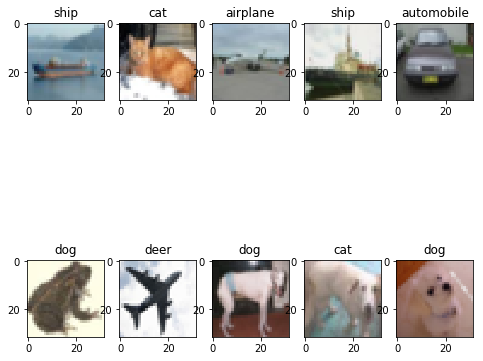

In [14]:
# set prediction tensors
pred_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test},y=None, num_epochs=1, shuffle=False)
predictions = cifar_classifier.predict(input_fn=pred_input_fn)

# sample plot
fig=plt.figure(figsize=(8, 8))

# dataframe to store and save results
df = pd.DataFrame(columns=['id','label'])

# prediction progress bar
tqdm_iter = tqdm(list(zip(predictions,filenames)))
tqdm_iter.set_description('Predicted -> ')

# image count
img_count = 0

# numpy array
npy = []

# iterations
for index, (prediction, filename) in enumerate(tqdm_iter):
    # extract picture id
    pic_id = int(filename.split(os.sep)[-1].split('.')[0])
    
    # extract label
    label = ID2LABEL[prediction['classes']]
    
    # save probability
    npy.append(prediction['unnorm_prob'])
    
    # store information
    df = df.append({'id':pic_id - 1,'label':label},ignore_index=True,verify_integrity=True)
    
    # plot first MAX_IMG images
    if img_count < MAX_IMG and np.random.random() >= 0.9:
        img_count += 1
        img=mpimg.imread(filename)
        fig.add_subplot(IMG_ROW, IMG_COL, img_count)
        plt.title(label)
        plt.imshow(img)

# sort by picture id
df = df.sort_values(by=['id']).set_index(['id'])

# save values into csv file
df.to_csv(OUTPUT_FILE)

# save npy
save_predictions(os.path.join(MODEL_DIR,NPY_FILENAME),np.array(npy))

In [15]:
# show
df

,label
id,
0,horse
1,automobile
2,frog
3,automobile
4,truck
5,cat
6,bird
7,dog
8,truck


In [16]:
# load .npy file
np.load(os.path.join(MODEL_DIR,NPY_FILENAME))

array([[-0.9257586 , -2.5615373 ,  1.258325  , ...,  8.709028  ,
        -4.264289  ,  0.32379293],
       [ 0.6972232 ,  0.08815287,  3.974398  , ..., -0.71674335,
        -0.67154825, -0.9358049 ],
       [ 5.5359974 ,  7.3779244 ,  1.7272747 , ..., -3.9825225 ,
         6.027877  ,  2.3609831 ],
       ...,
       [ 0.63956666,  1.640133  , -0.8081644 , ...,  0.03086492,
         1.7652901 ,  3.0841644 ],
       [ 2.053416  , -1.5940784 ,  4.2643237 , ...,  2.8480551 ,
         0.01047051, -0.26358038],
       [ 1.3190784 , -1.0970719 ,  3.44794   , ...,  2.8510246 ,
         0.02991277, -0.17363034]], dtype=float32)